# Default Payment prediction using supervised learning #

## Introduction
According to Federal Reserve Economic Data, credit card delinquency rates have been increasing since 2016 (sharp decrease in Q1 2020 is due to COVID relief measures).The bank performs a charge-off on delinquent credit cards and eats the losses. If only there was a way to predict which customers had the highest probability of defaulting so it may be prevented…
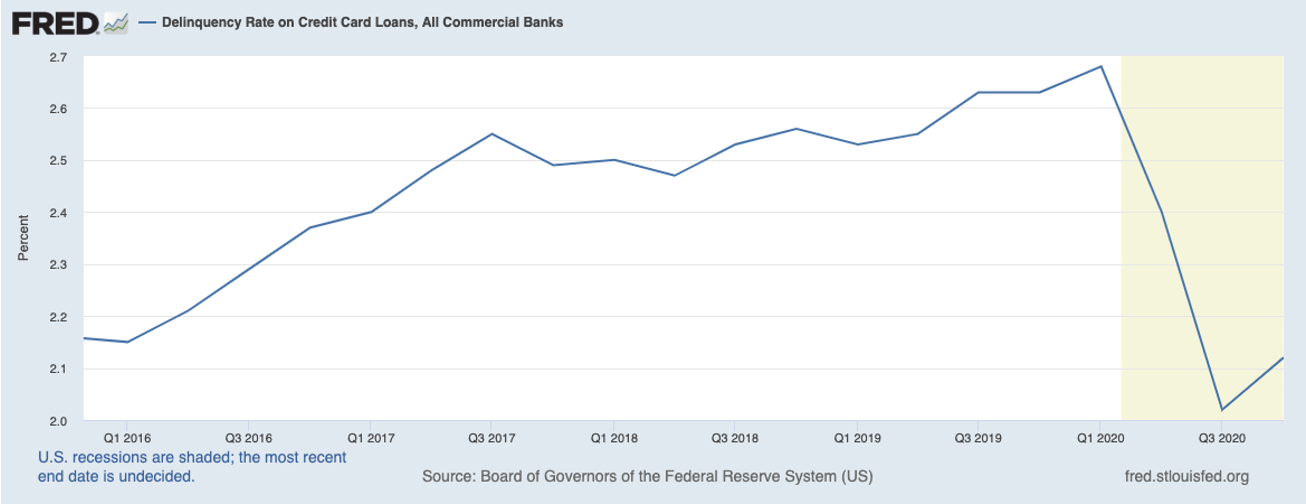

# Problem
Can we reliably predict who is likely to default based on available data for risk management purpose? 

# Data
Source: UC Irvine’s machine learning repository: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients


# Import packages

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score
import warnings
from tqdm import tqdm
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

warnings.filterwarnings('ignore')
%matplotlib inline

# Data cleaning

In [3]:
data_path = "/content/drive/MyDrive/data/default of credit card clients.csv"
df = pd.read_csv(data_path)
df = df.rename(columns={"default payment next month":"default_pay"})
df = df.drop(columns=['ID'])
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 30000 rows and 24 columns


In [4]:
 ##There are no nans
df.isnull().any().any()

False

# Exploratory data analysis

Text(1, 25, '22.12%')

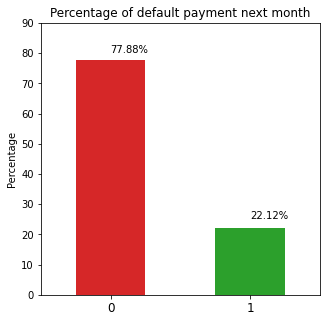

In [5]:
default_pay_prob = df.default_pay.value_counts(normalize=True)*100
ax = default_pay_prob.plot.bar(figsize=(5,5),color=['tab:red','tab:green'])
plt.xticks(fontsize=12, rotation=0)
plt.ylabel('Percentage')
plt.title('Percentage of default payment next month');
plt.ylim((0,90))
ax.text(0,80,'77.88%')
ax.text(1,25,'22.12%')

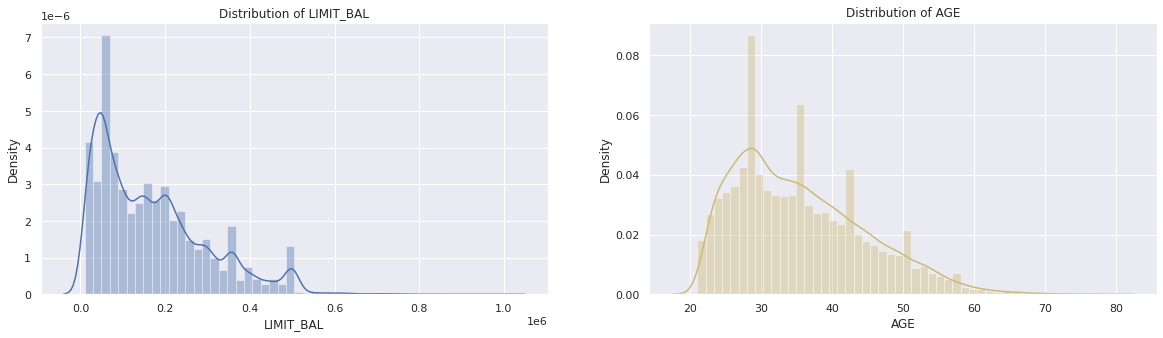

In [6]:
sns.set_theme()
plt.subplots(figsize=(20,5))
plt.subplot(121)
ax1 = sns.distplot(df.LIMIT_BAL,color='b')
plt.subplot(122)
ax2 = sns.distplot(df.AGE,color='y')
ax1.set_title('Distribution of LIMIT_BAL')
ax2.set_title('Distribution of AGE');

In [7]:
df.EDUCATION.unique()

array([2, 1, 3, 5, 4, 6, 0])

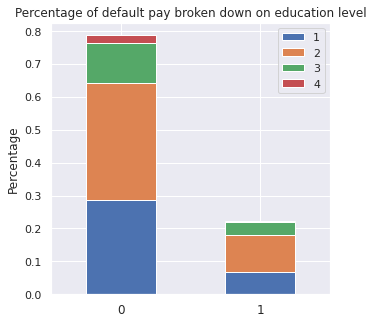

In [8]:
##breakdown in education
counts = pd.DataFrame({'0':df[df['default_pay']==0]['EDUCATION'].value_counts()/len(df),
                       '1':df[df['default_pay']==1]['EDUCATION'].value_counts()/len(df)})
counts = counts.fillna(0)
counts.iloc[4] = counts.iloc[0]+counts.iloc[4]+counts.iloc[5]+counts.iloc[5]
counts = counts.drop(index=[0,5,6])
counts = counts.transpose()
ax = counts.plot.bar(figsize=(5,5),stacked=True)
ax.set_ylabel('Percentage')
plt.xticks(fontsize=12, rotation=0)
plt.title('Percentage of default pay broken down on education level');



In [9]:
# plt.subplots(figsize=(30,20))
# sns.heatmap(df.corr(), annot=True)
# plt.show()

In [10]:
bill = ['BILL_AMT{}'.format(i) for i in range(1,7)]
pay = ['PAY_AMT{}'.format(i) for i in range(1,7)]
df['avg_bill'] = df[bill].mean(axis=1)
df['avg_pay'] = df[pay].mean(axis=1)

In [11]:
# sns.pairplot(df[bill+pay])

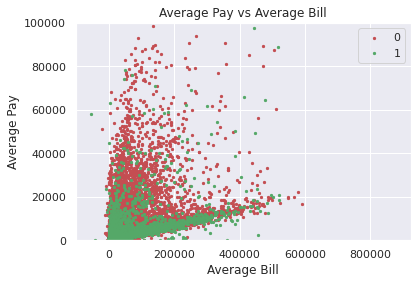

In [12]:
# plt.scatter(df['avg_bill'],df['avg_pay'],color=df['default_pay'])
plt.scatter(df['avg_bill'][df['default_pay']==0],df['avg_pay'][df['default_pay']==0],s=5,color='r',label='0')
plt.scatter(df['avg_bill'][df['default_pay']==1],df['avg_pay'][df['default_pay']==1],s=5,color='g',label='1')
plt.legend()
plt.ylim((0,100000))
plt.xlabel('Average Bill')
plt.ylabel('Average Pay')
plt.title('Average Pay vs Average Bill');

In [13]:
# sns.pairplot(df[bill+pay])

# Initial comparison among different classification models

In [14]:
##preparing data for model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df,test_size=0.25,random_state=0)
X_train, y_train = train_data.drop(columns=['default_pay','avg_bill','avg_pay']), train_data['default_pay']
X_test, y_test = test_data.drop(columns=['default_pay','avg_bill','avg_pay']), test_data['default_pay']
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(22500, 23) (22500,) (7500, 23) (7500,)


100%|██████████| 5/5 [03:27<00:00, 41.42s/it]


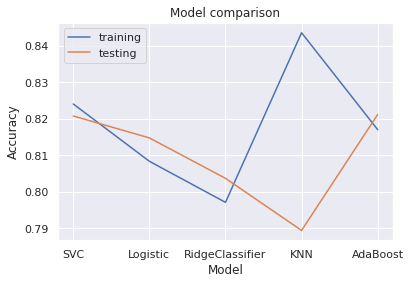

In [15]:
##First try on SVC using default parametes

models = [SVC(probability=True),LogisticRegression(), RidgeClassifier(), KNeighborsClassifier(), AdaBoostClassifier()]
training_acc = []
test_acc = []
roc = []
for model in tqdm(models):
  clf = make_pipeline(StandardScaler(),model).fit(X_train,y_train)
  training_acc.append(clf.score(X_train,y_train))
  test_acc.append(clf.score(X_test,y_test))
plt.plot(training_acc,label='training')
plt.plot(test_acc,label='testing')
plt.xlabel('Model')
plt.xticks(np.arange(5),['SVC','Logistic','RidgeClassifier','KNN','AdaBoost'])
plt.ylabel('Accuracy')
plt.title('Model comparison')
plt.legend()

# Fine tuning

100%|██████████| 9/9 [13:11<00:00, 87.98s/it] 


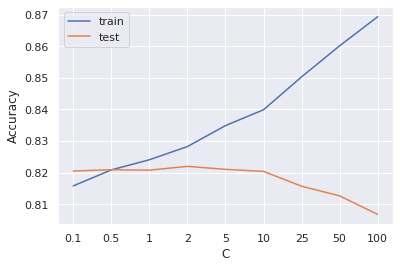

In [16]:
## choosing C using rbf for SVC
C = [0.1,0.5,1,2,5,10,25,50,100]
test_accuracy = []
train_accuracy = []
for c in tqdm(C):
  clf = make_pipeline(StandardScaler(), SVC(C=c))
  clf.fit(X_train,y_train)
  test_accuracy.append(clf.score(X_test,y_test))
  train_accuracy.append(clf.score(X_train,y_train))
ax = plt.subplot(111)
ax.plot(train_accuracy,label='train')
ax.plot(test_accuracy,label='test')
ax.set_xticks(ticks=np.arange(9))
ax.set_xticklabels(C);
ax.set_ylabel('Accuracy')
ax.set_xlabel('C')
plt.legend();

100%|██████████| 4/4 [03:17<00:00, 49.30s/it]


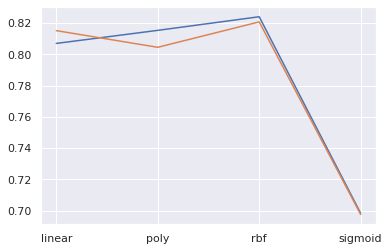

In [17]:
## choosing kernel functions in SVC
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
test_accuracy = []
train_accuracy = []
for k in tqdm(kernel):
  clf = make_pipeline(StandardScaler(), SVC(kernel=k)).fit(X_train,y_train)
  test_accuracy.append(clf.score(X_test,y_test))
  train_accuracy.append(clf.score(X_train,y_train))
ax = plt.subplot(111)
ax.plot(train_accuracy)
ax.plot(test_accuracy)
ax.set_xticks(ticks=np.arange(4))
ax.set_xticklabels(kernel);

100%|██████████| 10/10 [01:38<00:00,  9.86s/it]


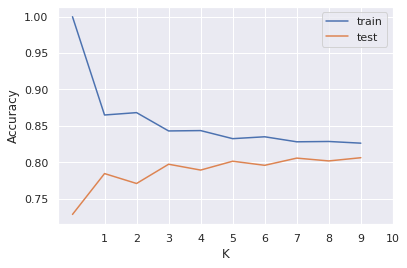

In [18]:
#choosing k in KNN
K = np.arange(1,11)
test_accuracy = []
train_accuracy = []
for k in tqdm(K):
  clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
  clf.fit(X_train,y_train)
  test_accuracy.append(clf.score(X_test,y_test))
  train_accuracy.append(clf.score(X_train,y_train))
ax = plt.subplot(111)
ax.plot(train_accuracy,label='train')
ax.plot(test_accuracy,label='test')
ax.set_xticks(ticks=np.arange(1,11))
ax.set_xticklabels(K);
ax.set_ylabel('Accuracy')
ax.set_xlabel('K')
plt.legend();

100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


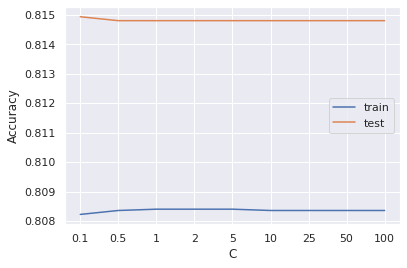

In [19]:
#choose C in logistic regression
C = [0.1,0.5,1,2,5,10,25,50,100]
test_accuracy = []
train_accuracy = []
for c in tqdm(C):
  clf = make_pipeline(StandardScaler(), LogisticRegression(C=c))
  clf.fit(X_train,y_train)
  test_accuracy.append(clf.score(X_test,y_test))
  train_accuracy.append(clf.score(X_train,y_train))
ax = plt.subplot(111)
ax.plot(train_accuracy,label='train')
ax.plot(test_accuracy,label='test')
ax.set_xticks(ticks=np.arange(len(C)))
ax.set_xticklabels(C);
ax.set_ylabel('Accuracy')
ax.set_xlabel('C')
plt.legend();

Text(0.5, 1.0, 'Feature importance')

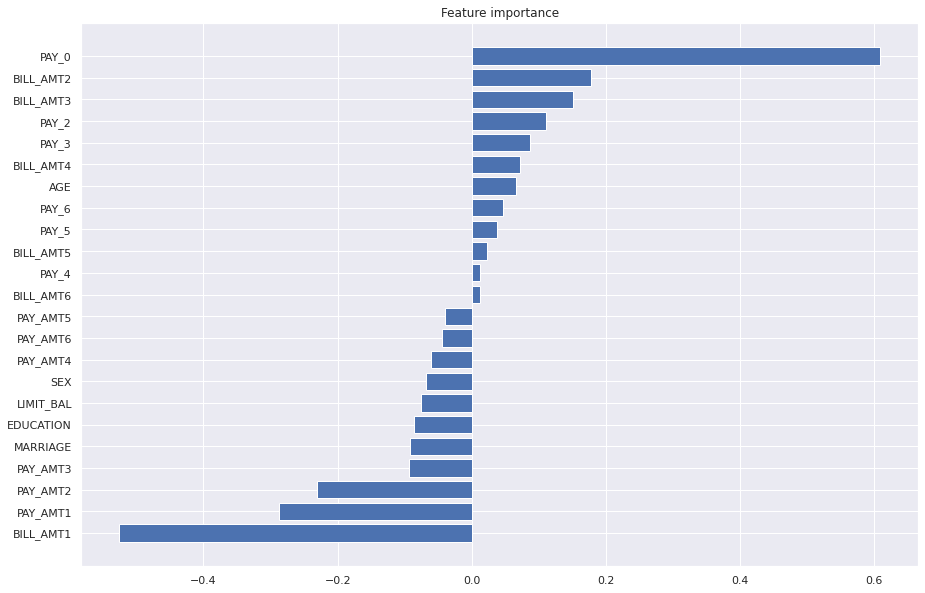

In [20]:
#Plot feature importance
log = LogisticRegression()
clf = make_pipeline(StandardScaler(),log)
clf.fit(X_train,y_train)
fig,ax = plt.subplots(figsize=(15,10))
imp = log.coef_.reshape((23,))
names = df.columns.tolist()
imp,names = zip(*sorted(zip(imp,names)))
ax.barh(range(len(names)), imp, align='center')
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_title('Feature importance')

Text(0.5, 1.0, 'ROC of best SVC')

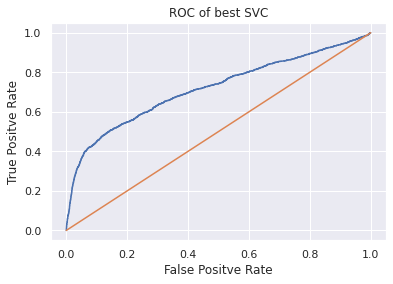

In [21]:
##best model
clf = make_pipeline(StandardScaler(), SVC(probability=True)).fit(X_train,y_train)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_log_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.xlabel('False Positve Rate')
plt.ylabel('True Positve Rate')
plt.title('ROC of best SVC')

In [22]:
print('Test recall is ', recall_score(y_test,clf.predict(X_test)))
print('Test precision is ', precision_score(y_test,clf.predict(X_test)))
print('Test accuracy is ', clf.score(X_test,y_test))

Test recall is  0.33026960784313725
Test precision is  0.6822784810126582
Test accuracy is  0.8208


Text(0.5, 1.0, 'Confution matrix of SVC')

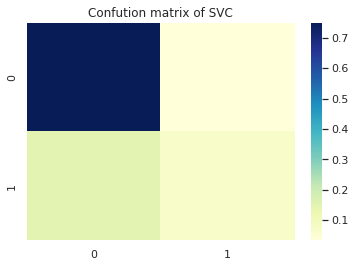

In [23]:
con_mat = confusion_matrix(y_test,clf.predict(X_test))
sns.heatmap(con_mat/7500,cmap='YlGnBu')
plt.title('Confution matrix of SVC')

# Feature engineering

100%|██████████| 9/9 [14:02<00:00, 93.65s/it] 


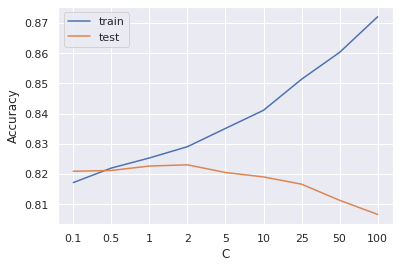

In [24]:
#Reducing the number of features by taking the difference on the bill and payment in each month
df[['dif1','dif2','dif3','dif4','dif5','dif6']] = df[bill].to_numpy()-df[pay].to_numpy()
X = df.drop(columns=bill+pay+['avg_bill','avg_pay','default_pay'])
y = df['default_pay']
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)
C = [0.1,0.5,1,2,5,10,25,50,100]
test_accuracy = []
train_accuracy = []
for c in tqdm(C):
  clf = make_pipeline(StandardScaler(), SVC(C=c))
  clf.fit(X_train,y_train)
  test_accuracy.append(clf.score(X_test,y_test))
  train_accuracy.append(clf.score(X_train,y_train))
ax = plt.subplot(111)
ax.plot(train_accuracy,label='train')
ax.plot(test_accuracy,label='test')
ax.set_xticks(ticks=np.arange(9))
ax.set_xticklabels(C);
ax.set_ylabel('Accuracy')
ax.set_xlabel('C')
plt.legend();

# Summary
Best model is SVC(C=2), after some feature engineering. With test accuracy being 82.3%.
# Future Plans
1. Use some model time series data to exploit the pay and bill data in a sequential fashion
2. Use deep neural net work to predict.
